In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report

dataset = np.genfromtxt('prices250.txt').transpose() #dataset shape - each row is different instruments, columns are days
(ninst,nt) = dataset.shape
df = pd.DataFrame(dataset.transpose())

formatted_df = pd.DataFrame(columns=['instrument', 'day', 'price'])
i = 0
while i < ninst:
    temp = df[i]
    temp = temp.values.flatten()
    instr = np.full((nt,),i)
    da = np.linspace(0,nt-1, num=nt)

    stock_df = pd.DataFrame({'instrument':instr, 'day':da, 'price':temp})
    formatted_df = formatted_df.append(stock_df, ignore_index=True)

    i+=1
    
price_data = formatted_df.copy()
daily_predict = formatted_df.copy()

price_data['change_in_price'] = price_data.groupby('instrument')['price'].diff()

# Calculate the 14 day RSI
n = 14
up_df, down_df = price_data[['instrument','change_in_price']].copy(), price_data[['instrument','change_in_price']].copy()
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0
down_df['change_in_price'] = down_df['change_in_price'].abs()
ewma_up = up_df.groupby('instrument')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('instrument')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
relative_strength = ewma_up / ewma_down
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI_14'] = relative_strength_index

# Calculate the Stochastic RSI 14
n = 14
low_14, high_14 = price_data[['instrument','RSI_14']].copy(), price_data[['instrument','RSI_14']].copy()
low_14 = low_14.groupby('instrument')['RSI_14'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('instrument')['RSI_14'].transform(lambda x: x.rolling(window = n).max())
STOCH_RSI = (price_data['RSI_14'] - low_14) / (high_14 - low_14)

price_data['STOCH_RSI'] = STOCH_RSI

# Calculate the Stochastic Oscillator
n = 14
low_14, high_14 = price_data[['instrument','price']].copy(), price_data[['instrument','price']].copy()
low_14 = low_14.groupby('instrument')['price'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('instrument')['price'].transform(lambda x: x.rolling(window = n).max())
k_percent = 100 * ((price_data['price'] - low_14) / (high_14 - low_14))

price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

# Calculate the MACD
ema_26 = price_data.groupby('instrument')['price'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('instrument')['price'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26
ema_9_macd = macd.ewm(span = 9).mean()

price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd


# Calculate the Price Rate of Change
n = 9
price_data['Price_Rate_Of_Change'] = price_data.groupby('instrument')['price'].transform(lambda x: x.pct_change(periods = n))


#Bollinger Band; Generates a value greater than 1 if above upper bound, lower than -1 for below lower band, -1<val<1 for between bands
n = 12
sma12 = price_data.groupby('instrument')['price'].transform(lambda x: x.rolling(n).mean())
std12 = price_data.groupby('instrument')['price'].transform(lambda x: x.rolling(n).std())   
upper = sma12 + 2*std12
lower = sma12 - 2*std12    
BollingerVal = (2 * (price_data['price'] - sma12)) / (upper - lower)
    
price_data['BOLL'] = BollingerVal
    
price_data.head()

,instrument,day,price,change_in_price,down_days,up_days,RSI_14,STOCH_RSI,low_14,high_14,k_percent,MACD,MACD_EMA,Price_Rate_Of_Change,BOLL
0,0,0.0,18.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
1,0,1.0,18.22,-0.03,0.03,0.00,0.000000,NaN,NaN,NaN,NaN,-0.000673,-0.000374,NaN,NaN
2,0,2.0,18.28,0.06,0.00,0.06,69.767442,NaN,NaN,NaN,NaN,0.001003,0.000190,NaN,NaN
3,0,3.0,18.07,-0.21,0.21,0.00,18.275539,NaN,NaN,NaN,NaN,-0.005841,-0.001853,NaN,NaN
4,0,4.0,18.20,0.13,0.00,0.13,46.486652,NaN,NaN,NaN,NaN,-0.004264,-0.002570,NaN,NaN


In [13]:
close_groups = price_data.groupby('instrument')['price']

close_groups = close_groups.transform(lambda x : -x.diff(periods=-1)/x)

price_data['prc_change'] = close_groups

classifications = [
    (price_data['prc_change'] < -0.005),
    (price_data['prc_change'] >= -0.005) & (price_data['prc_change'] <= 0.005),
    (price_data['prc_change'] > 0.005)
]

values = [-1, 0, 1]

price_data['Prediction'] = np.select(classifications, values)


price_data.head(15)

,instrument,day,price,change_in_price,down_days,up_days,RSI_14,STOCH_RSI,low_14,high_14,k_percent,MACD,MACD_EMA,Price_Rate_Of_Change,BOLL,prc_change,Prediction
0,0,0.0,18.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,-0.001644,0
1,0,1.0,18.22,-0.03,0.03,0.00,0.000000,NaN,NaN,NaN,NaN,-0.000673,-0.000374,NaN,NaN,0.003293,0
2,0,2.0,18.28,0.06,0.00,0.06,69.767442,NaN,NaN,NaN,NaN,0.001003,0.000190,NaN,NaN,-0.011488,-1
3,0,3.0,18.07,-0.21,0.21,0.00,18.275539,NaN,NaN,NaN,NaN,-0.005841,-0.001853,NaN,NaN,0.007194,1
4,0,4.0,18.20,0.13,0.00,0.13,46.486652,NaN,NaN,NaN,NaN,-0.004264,-0.002570,NaN,NaN,-0.002747,0
5,0,5.0,18.15,-0.05,0.05,0.00,40.311204,NaN,NaN,NaN,NaN,-0.005374,-0.003330,NaN,NaN,0.004959,0
6,0,6.0,18.24,0.09,0.00,0.09,53.218488,NaN,NaN,NaN,NaN,-0.001916,-0.002972,NaN,NaN,0.008224,1
7,0,7.0,18.39,0.15,0.00,0.15,66.958754,NaN,NaN,NaN,NaN,0.007567,-0.000440,NaN,NaN,-0.002719,0
8,0,8.0,18.34,-0.05,0.05,0.00,60.162447,NaN,NaN,NaN,NaN,0.011538,0.002327,NaN,NaN,0.003817,0
9,0,9.0,18.41,0.07,0.00,0.07,65.774163,NaN,NaN,NaN,NaN,0.017793,0.005793,0.008767,NaN,-0.002716,0


In [14]:
price_data.replace([np.inf, -np.inf], np.nan, inplace=True)
price_data = price_data.dropna()

In [15]:
X_Cols = price_data[['RSI_14','STOCH_RSI','k_percent','Price_Rate_Of_Change','MACD','MACD_EMA','BOLL']]
Y_Cols = price_data['Prediction']

X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, test_size = 0.2, random_state = 42)

rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 42)

rand_frst_clf.fit(X_train, y_train)

y_pred = rand_frst_clf.predict(X_test)

In [16]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  58.02310654685494


In [6]:
target_names = ['Down Day', 'Stagnant Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.554092,0.527741,0.540595,1514.000000
Stagnant Day,0.594249,0.690594,0.638809,1616.000000
Up Day,0.588626,0.516192,0.550035,1544.000000
accuracy,0.580231,0.580231,0.580231,0.580231
macro avg,0.578989,0.578176,0.576480,4674.000000
weighted avg,0.579384,0.580231,0.577670,4674.000000


Accuracy: 0.7442673921492421
Percision: 0.7464882943143812
Recall: 0.8
Specificity: 0.6782682512733447


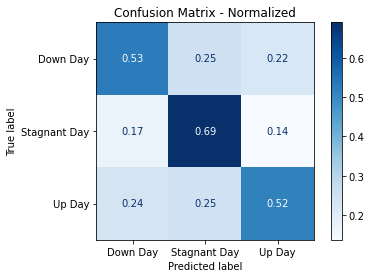

In [7]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(y_test, y_pred)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

disp = plot_confusion_matrix(rand_frst_clf, X_test, y_test, display_labels = ['Down Day', 'Stagnant Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()

In [8]:
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

Price_Rate_Of_Change    0.194459
RSI_14                  0.184615
BOLL                    0.144251
MACD                    0.130603
MACD_EMA                0.128614
STOCH_RSI               0.114377
k_percent               0.103079
dtype: float64

In [10]:
print('Random Forest Out-Of-Bag Error Score: {}'.format(rand_frst_clf.oob_score_))
rand_frst_clf.score(X_test, y_test)

Random Forest Out-Of-Bag Error Score: 0.5735986307231493


0.5802310654685494

In [11]:
import pickle
with open('rfc_comm.pickle', 'wb') as f:
    pickle.dump(rand_frst_clf, f)